<a href="https://colab.research.google.com/github/robfreitas96/PucMg_ML/blob/main/Diabetes_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de Dados de Diabetes Utilizando Machine Learning

Neste notebook, iremos realizar uma análise de um dataset de diabetes, focando na preparação de dados, análise exploratória
e aplicação de algoritmos de aprendizado de máquina. Usaremos o conjunto de dados `diabetes.csv`, que contém diversas
informações clínicas dos pacientes, como níveis de glicose, pressão arterial e índice de massa corporal (BMI).
Importação de Bibliotecas e Carregamento de Dados

In [3]:
!pip install openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [5]:
# Carregar o dataset
file_path = 'diabetes.csv'
diabetes_data = pd.read_csv(file_path)

# Exibir as primeiras linhas do dataset
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#Estatísticas Descritivas
Aqui, apresentamos um resumo estatístico dos dados, que nos permite observar a distribuição das variáveis.


In [6]:
#Exibir estatísticas descritivas
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


A análise estatística descritiva do dataset revela os seguintes pontos:


*   Glucose: O valor médio da glicose é 120.9, com valores variando de 0 a 199. Um valor de glicose igual a 0 parece indicar dados ausentes ou inválidos.
*   BloodPressure: A pressão arterial média é 69.1 mm Hg, com alguns valores mínimos de 0, o que não é biologicamente plausível e pode indicar dados ausentes.
*   SkinThickness e Insulin: Ambas as variáveis possuem valores mínimos de 0, o que pode sugerir ausência de medições para alguns pacientes.
*   BMI: O Índice de Massa Corporal (IMC) médio é 31.99, com uma amplitude que vai de 0 a 67.1. Valores de BMI igual a 0 indicam dados faltantes.
Age: A idade média dos pacientes é de 33 anos, com um intervalo variando de 21 a 81 anos.
*   Outcome: A distribuição de pessoas diagnosticadas com diabetes é de aproximadamente 35%, enquanto 65% não têm diabetes.

#Tratamento de Valores Ausentes
Valores zeros em variáveis como glicose, pressão arterial, espessura da pele, insulina e BMI não fazem sentido biológio e clínico. Vamos analisar quais colunas apresentam mais valores 0 e qual seria a sua porcentagem.

In [7]:
# Substituir valores 0 nas colunas que não podem ter esse valor por suas respectivas medianas
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Contar a quantidade de zeros por coluna
zero_counts = (diabetes_data[columns_with_zeros] == 0).sum()

# Exibir o resultado
zero_counts

,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


In [8]:
# Calcular a porcentagem de valores zero na coluna 'Insulin'
total_rows = diabetes_data.shape[0]
zero_insulin_count = (diabetes_data['Insulin'] == 0).sum()
percentage_zero_insulin = (zero_insulin_count / total_rows) * 100

percentage_zero_insulin

48.69791666666667

Quase 50% dos dados contém o valor de insulina igual a 0. Vamos analisar a correlação que os valores de SkinThickness e Insulin possuem com o Outcome, isto é, se a paciente tem ou não Diabetes.

In [9]:
# Calcular a correlação entre as colunas 'Insulin', 'SkinThickness' e 'Outcome'
correlation_insulin_outcome = diabetes_data['Insulin'].corr(diabetes_data['Outcome'])
correlation_skinthickness_outcome = diabetes_data['SkinThickness'].corr(diabetes_data['Outcome'])

# Exibir os resultados
correlation_insulin_outcome, correlation_skinthickness_outcome

(0.13054795488404794, 0.0747522319183194)

As correlações entre as colunas Insulin e SkinThickness com o Outcome (presença de diabetes) são:

*   Insulin: 0.13
*   SkinThickness: 0.075

Esses valores indicam uma correlação fraca entre essas variáveis e o diagnóstico de diabetes (Outcome). Embora elas possam fornecer informações úteis no modelo, essas variáveis, por si só, não têm uma relação muito forte com o desfecho de diabetes. Sendo assim, vamos seguir fazendo a substituição dos valores 0 pelas medianas de cada coluna.

In [10]:
# Substituindo 0 pela mediana de cada coluna
for column in columns_with_zeros:
    median_value = diabetes_data[column].median()
    diabetes_data[column] = diabetes_data[column].replace(0, median_value)

# Verificando novamente os dados após a substituição
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Para uma análise mais exploratória e levantar hipóteses, vamos começar investigando padrões nos dados e características que possam estar associadas à ocorrência de diabetes. Abaixo estão os passos que seguirei:

* Distribuição das Variáveis: Análise visual de distribuições para verificar a simetria e identificar possíveis anomalias.
* Comparação por Classes de Diabetes (Outcome): Explorar como as variáveis se comportam entre aqueles com diagnóstico positivo e negativo para diabetes.
* Identificação de Padrões por Faixas Etárias: Verificar se a idade influencia na presença de diabetes e análise da matriz de correlação para destacar relações potenciais entre as variáveis.

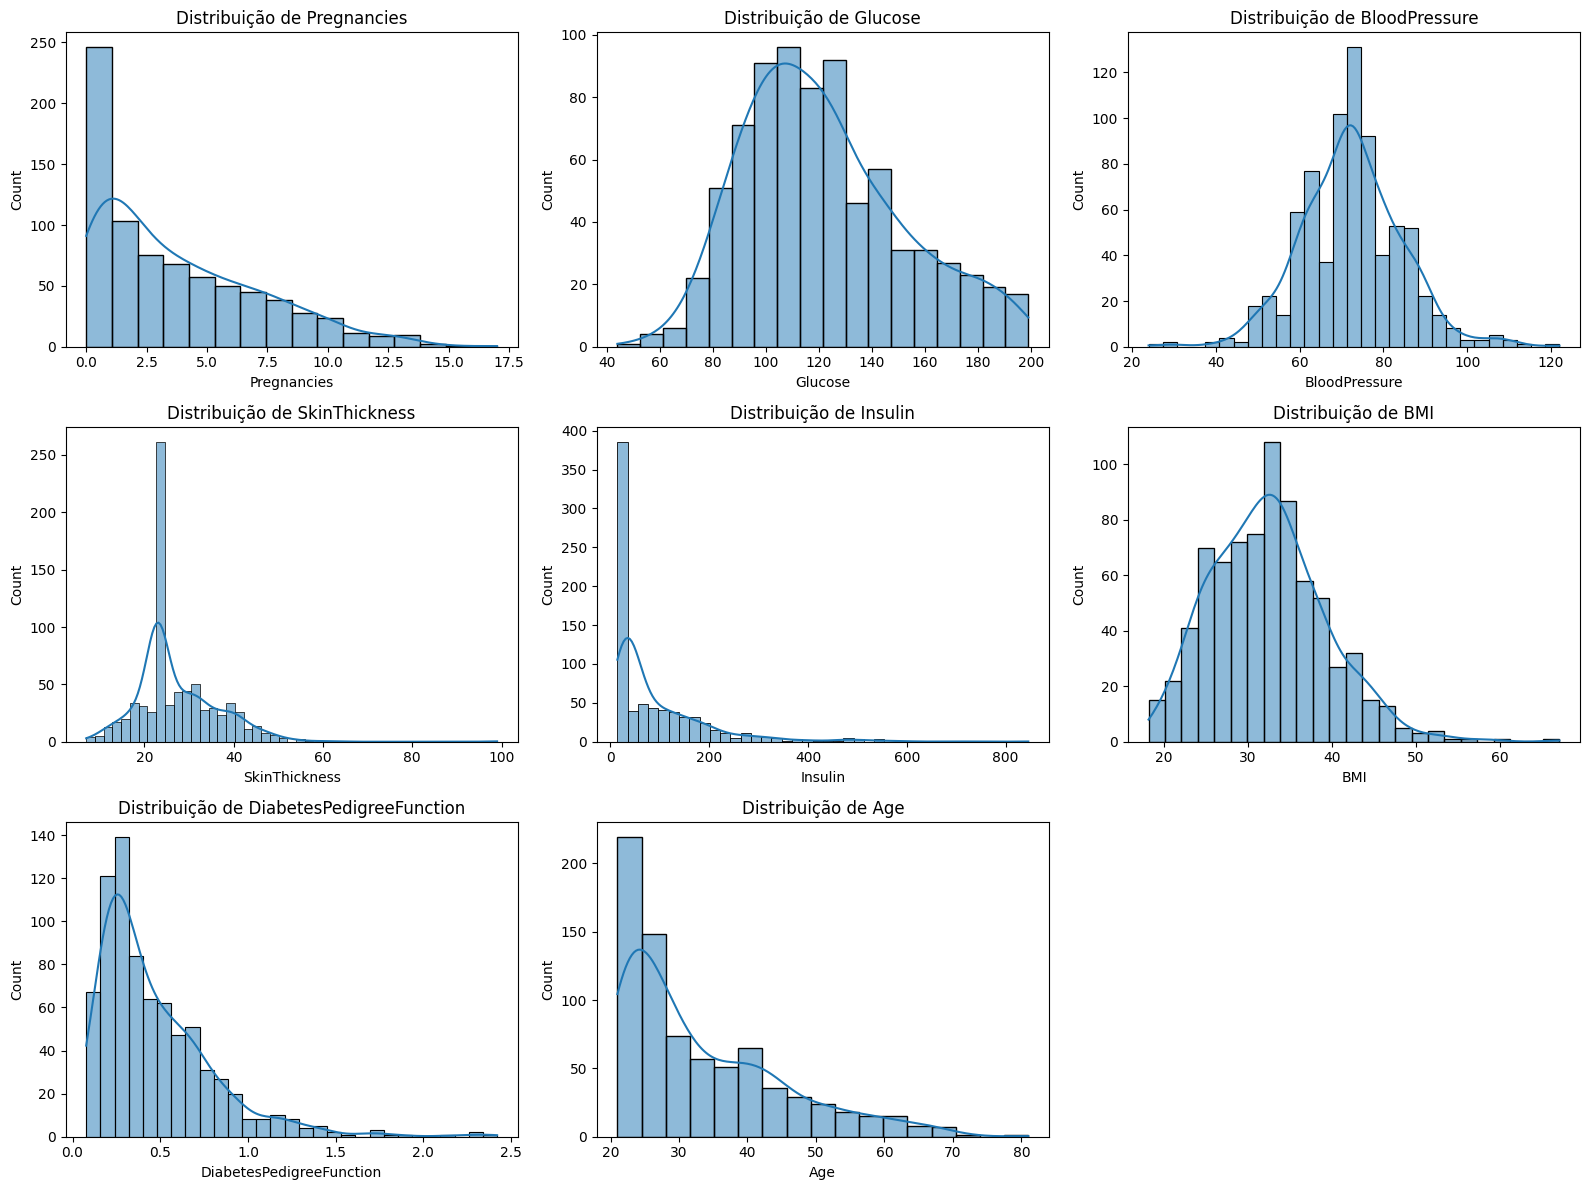

In [11]:
# 1. Visualização da Distribuição das Variáveis
plt.figure(figsize=(16, 12))
for i, col in enumerate(diabetes_data.columns[:-1], 1):  # Excluindo 'Outcome' da análise de distribuição
    plt.subplot(3, 3, i)
    sns.histplot(diabetes_data[col], kde=True)
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

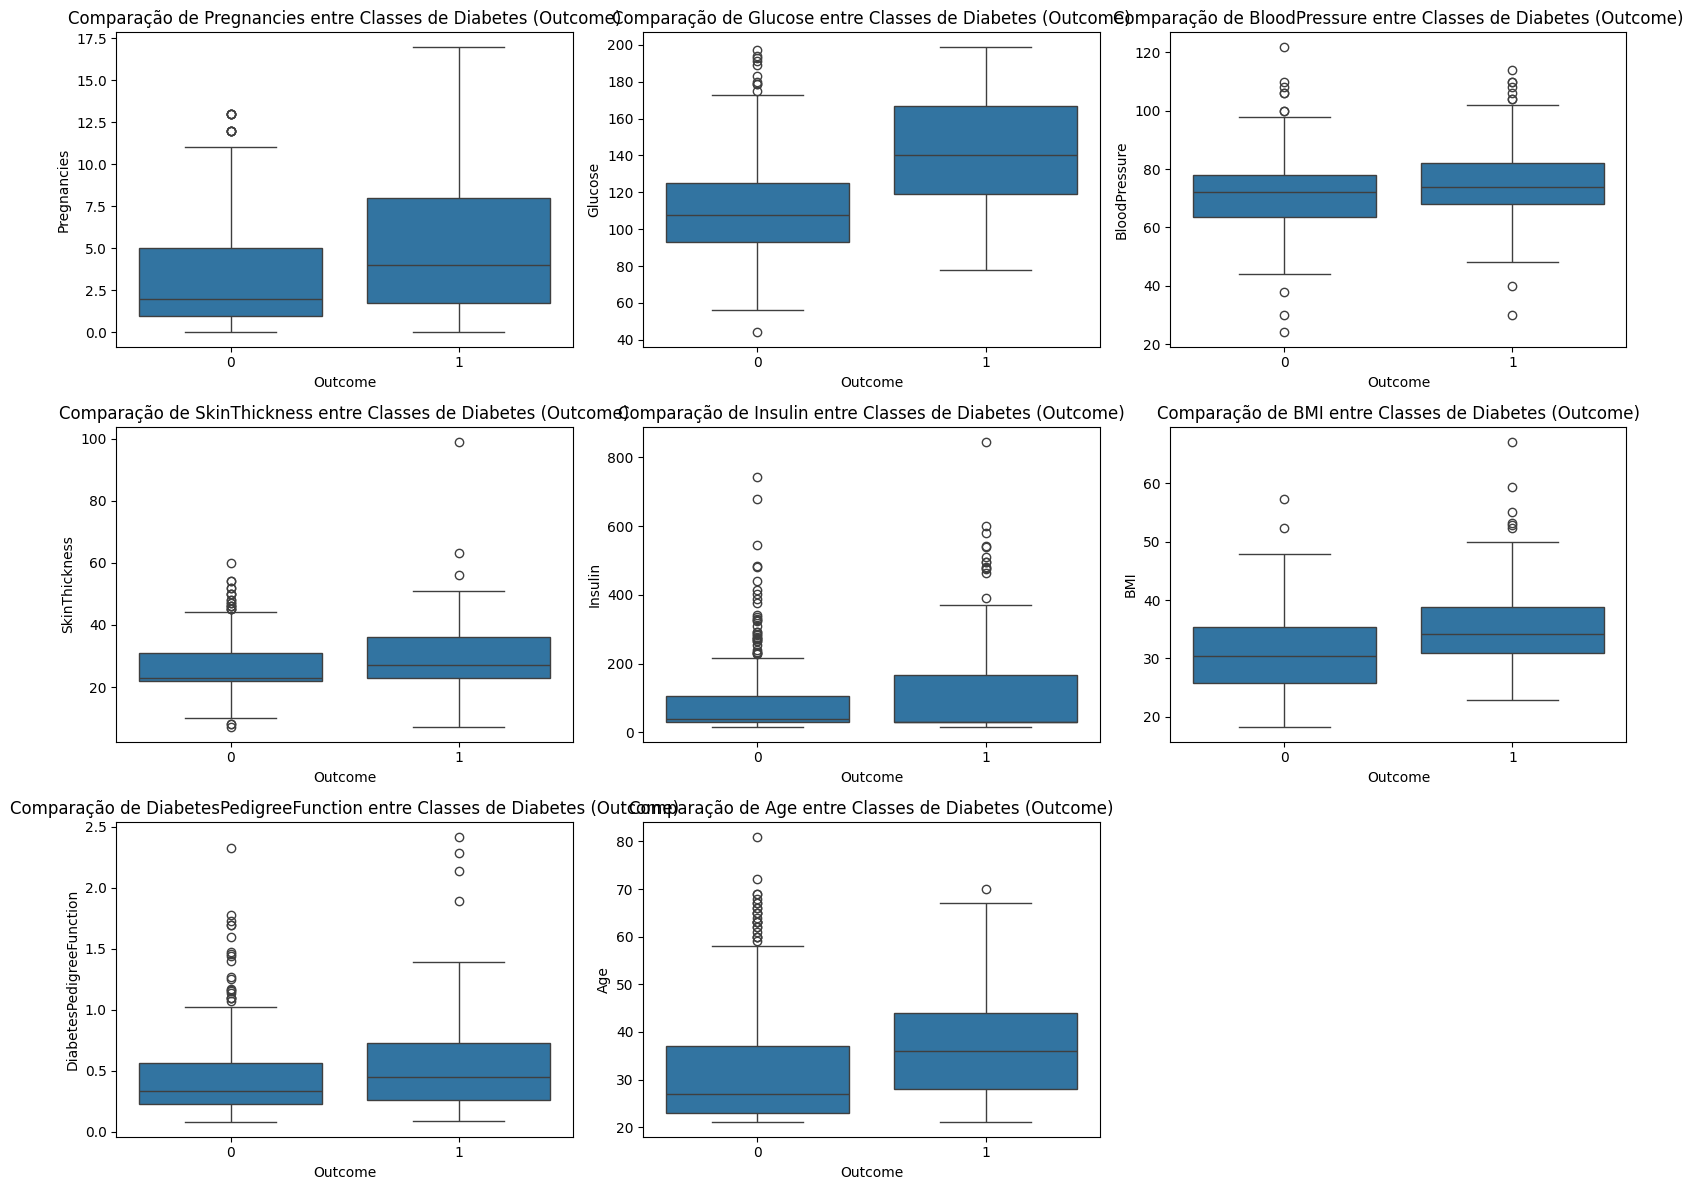

In [12]:
# 2. Comparação das Variáveis por Classes de Diabetes (Outcome)
plt.figure(figsize=(16, 12))
for i, col in enumerate(diabetes_data.columns[:-1], 1):  # Excluindo 'Outcome' por ser a variável alvo
    plt.subplot(3, 3, i)
    sns.boxplot(x='Outcome', y=col, data=diabetes_data)
    plt.title(f'Comparação de {col} entre Classes de Diabetes (Outcome)')
plt.tight_layout()
plt.show()

As visualizações iniciais revelam algumas observações:

1. Distribuição das Variáveis: A maioria das variáveis apresenta distribuições assimétricas, com algumas, como Pregnancies, Insulin, e SkinThickness, exibindo caudas longas, sugerindo a presença de valores extremos ou alta variabilidade em certos grupos.

2. Comparação entre Classes de Diabetes (Outcome):

* Glucose: Valores mais elevados de glicose parecem estar associados a um diagnóstico positivo de diabetes, o que é consistente com o conhecimento médico.
* BMI (Índice de Massa Corporal): Pessoas com diagnóstico positivo de diabetes tendem a ter valores mais altos de BMI, sugerindo uma possível associação entre sobrepeso e diabetes.
* Age (Idade): A idade também tende a ser mais elevada entre aqueles com diagnóstico positivo, indicando que a probabilidade de diabetes aumenta com a idade.

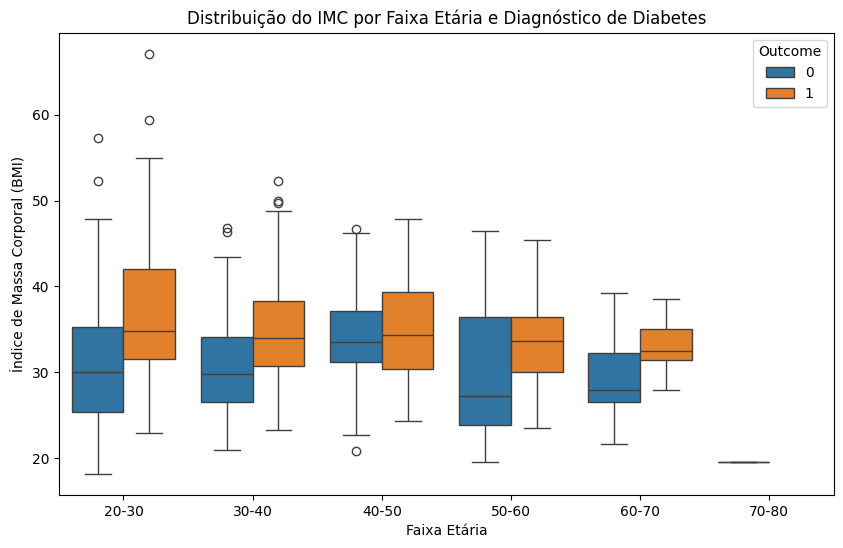

Outcome,0,1
AgeGroup,,
20-30,327,90
30-40,81,76
40-50,49,64
50-60,23,31
60-70,18,7
70-80,1,0


In [19]:
# Análise por Faixa Etária
# Criar faixas etárias para facilitar a análise
diabetes_data['AgeGroup'] = pd.cut(diabetes_data['Age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])

# 3. Análise do IMC entre os grupos etários
plt.figure(figsize=(10, 6))
sns.boxplot(x='AgeGroup', y='BMI', hue='Outcome', data=diabetes_data)
plt.title('Distribuição do IMC por Faixa Etária e Diagnóstico de Diabetes')
plt.xlabel('Faixa Etária')
plt.ylabel('Índice de Massa Corporal (BMI)')
plt.legend(title='Outcome', loc='upper right')
plt.show()

# Exibir contagem de casos de diabetes por grupo etário
age_group_outcome

A análise por faixa etária revela alguns padrões importantes:

* Distribuição do IMC por Faixa Etária: Em faixas etárias mais jovens (20-30 anos), tanto aqueles diagnosticados com diabetes quanto os não diagnosticados apresentam uma maior variabilidade no IMC. No entanto, nas faixas etárias acima de 40 anos, a tendência é de que aqueles com diabetes possuam um IMC consistentemente mais elevado.

* Diagnósticos de Diabetes por Idade: A maioria dos casos de diabetes ocorre nas faixas etárias de 20-30 e 30-40 anos, com uma redução significativa nos grupos de idade mais avançada. Isso pode sugerir que a amostra contém uma quantidade maior de indivíduos jovens, mas também pode indicar que o diagnóstico de diabetes é mais frequente em adultos jovens neste conjunto de dados.

Para complementar, posso explorar padrões em outros fatores, como níveis de glicose ou histórico familiar, entre esses grupos etários e com base no diagnóstico de diabetes.

Para aplicar modelos de aprendizado de máquina ao diagnóstico de diabetes, seguiremos as seguintes etapas:

1. Pré-processamento dos Dados:

* Divisão em Conjuntos de Treino e Teste: Dividir os dados em conjuntos de treino e teste para avaliar o desempenho do modelo.
* Normalização dos Dados: Normalizar as variáveis preditoras para melhorar a performance e a estabilidade de certos algoritmos, especialmente os baseados em distância.
2. Escolha de Modelos de Aprendizado de Máquina:

* Utilizaremos os seguintes algoritmos, baseados na simplicidade e capacidade de interpretar os resultados:
  * Regressão Logística: Bom para classificação binária e fácil de interpretar.
  * Árvore de Decisão: Útil para entender a hierarquia de decisões baseadas em variáveis.
  * Random Forest: Combina múltiplas árvores de decisão, aumentando a precisão e reduzindo o overfitting.
3. Avaliação dos Modelos:
* Métricas como acurácia, precisão, recall e a área sob a curva ROC serão utilizadas para avaliar o desempenho dos modelos.
Abaixo, inicio o processo com a divisão dos dados e a normalização.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separação entre variáveis preditoras e variável alvo
X = diabetes_data.drop(columns=['Outcome', 'AgeGroup'])  # Excluindo 'Outcome' (alvo) e 'AgeGroup' (variável derivada)
y = diabetes_data['Outcome']

# Divisão dos dados em conjuntos de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Exibir formas dos conjuntos de treino e teste para confirmar a divisão
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

Os dados foram divididos com sucesso em conjuntos de treino e teste:

* Conjunto de Treino: 614 registros
* Conjunto de Teste: 154 registros
Os dados também foram normalizados para melhorar o desempenho dos modelos.
A seguir, vamos aplicar os modelos de Regressão Logística, Árvore de Decisão e Random Forest e avaliar o desempenho de cada um. ​

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Dicionário para armazenar resultados de cada modelo
results = {}

# 1. Regressão Logística
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, y_pred_log_reg),
    'Precision': precision_score(y_test, y_pred_log_reg),
    'Recall': recall_score(y_test, y_pred_log_reg),
    'ROC AUC': roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
}

# 2. Árvore de Decisão
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)  # Árvore de Decisão sem normalização para analisar a diferença
y_pred_tree = decision_tree.predict(X_test)
results['Decision Tree'] = {
    'Accuracy': accuracy_score(y_test, y_pred_tree),
    'Precision': precision_score(y_test, y_pred_tree),
    'Recall': recall_score(y_test, y_pred_tree),
    'ROC AUC': roc_auc_score(y_test, decision_tree.predict_proba(X_test)[:, 1])
}

# 3. Random Forest
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_forest = random_forest.predict(X_test)
results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_forest),
    'Precision': precision_score(y_test, y_pred_forest),
    'Recall': recall_score(y_test, y_pred_forest),
    'ROC AUC': roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
}

# Exibir os resultados de desempenho de cada modelo em formato de DataFrame
performance_df = pd.DataFrame(results).T
performance_df


,Accuracy,Precision,Recall,ROC AUC
Logistic Regression,0.707792,0.600000,0.500000,0.815185
Decision Tree,0.668831,0.533333,0.444444,0.617222
Random Forest,0.759740,0.680851,0.592593,0.821759


Os resultados de desempenho dos modelos aplicados são os seguintes:

1. Regressão Logística:

* Acurácia: 70,8%
* Precisão: 60%
* Recall: 50%
* ROC AUC: 81,5%
2. Árvore de Decisão:
* Acurácia: 66,9%
* Precisão: 53,3%
* Recall: 44,4%
* ROC AUC: 61,7%
3. Random Forest:
* Acurácia: 75,9%
* Precisão: 68,1%
* Recall: 59,3%
* ROC AUC: 82,2%

A Random Forest apresentou o melhor desempenho em todas as métricas, especialmente em precisão e área sob a curva ROC (ROC AUC), mostrando maior capacidade de classificação dos casos de diabetes. A regressão logística também apresentou um desempenho sólido, sendo uma boa alternativa.

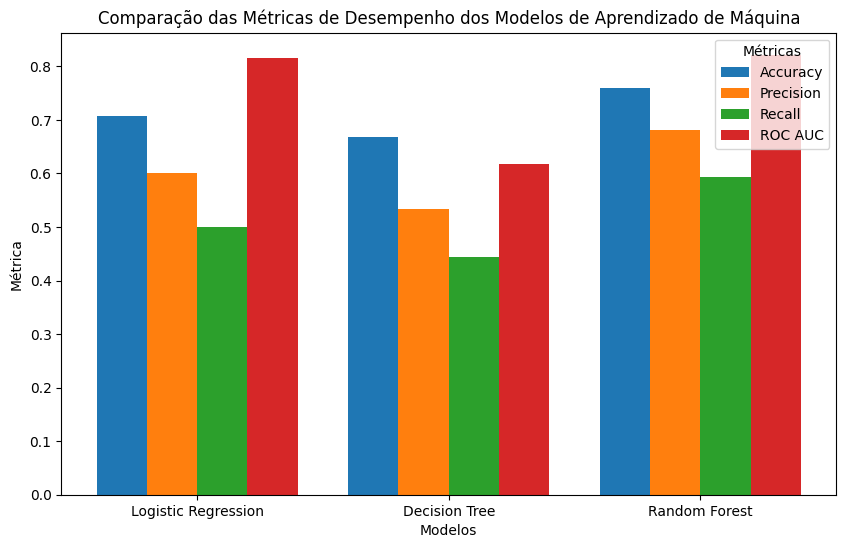

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Gráfico comparativo das métricas para cada modelo
metrics = ['Accuracy', 'Precision', 'Recall', 'ROC AUC']
model_names = list(results.keys())

# Extrair os valores das métricas para cada modelo
values = [list(performance_df.loc[model]) for model in model_names]

# Converter para formato numpy para facilitar o plot
values = np.array(values)

# Configurar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2  # Largura de cada barra

# Criar gráfico de barras agrupado para cada métrica
for i, metric in enumerate(metrics):
    ax.bar(np.arange(len(model_names)) + i * width, values[:, i], width, label=metric)

# Configurações do gráfico
ax.set_xticks(np.arange(len(model_names)) + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(model_names)
ax.set_xlabel('Modelos')
ax.set_ylabel('Métrica')
ax.set_title('Comparação das Métricas de Desempenho dos Modelos de Aprendizado de Máquina')
ax.legend(title='Métricas')

plt.show()


O gráfico acima apresenta uma comparação visual das métricas de desempenho dos três modelos de aprendizado de máquina utilizados:

1. Random Forest obteve os melhores resultados em todas as métricas, destacando-se em precisão (68,1%) e área sob a curva ROC (82,2%), o que o torna o modelo mais eficaz para o diagnóstico de diabetes neste dataset.

2. Regressão Logística também mostrou um bom desempenho, especialmente na área sob a curva ROC (81,5%), embora com recall e precisão ligeiramente mais baixos.

3. Árvore de Decisão teve um desempenho inferior, com uma área sob a curva ROC de 61,7%, sugerindo menor capacidade de generalização para este problema em comparação aos outros modelos.

Esses resultados sugerem que, para este conjunto de dados, o modelo de Random Forest é o mais indicado, enquanto a Regressão Logística pode ser uma alternativa mais interpretável.

Para uma análise mais detalhada do modelo Random Forest, vamos explorar os seguintes pontos:

1. Importância das Variáveis: Identificar as variáveis mais relevantes no processo de classificação.
2. Matriz de Confusão: Avaliar a performance do modelo em termos de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.
3. Curva ROC e AUC: Visualizar o trade-off entre taxa de verdadeiros positivos e taxa de falsos positivos para analisar a capacidade de discriminação do modelo.

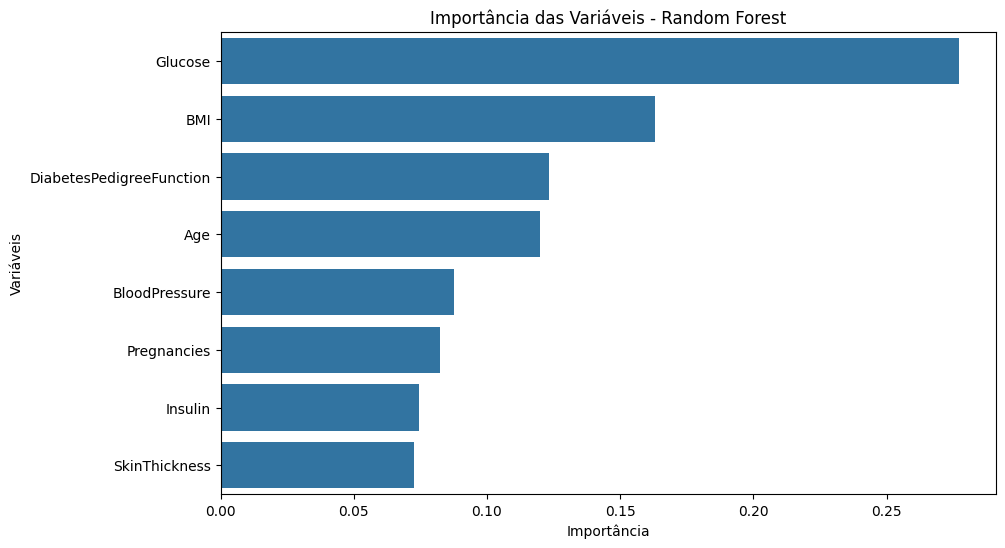

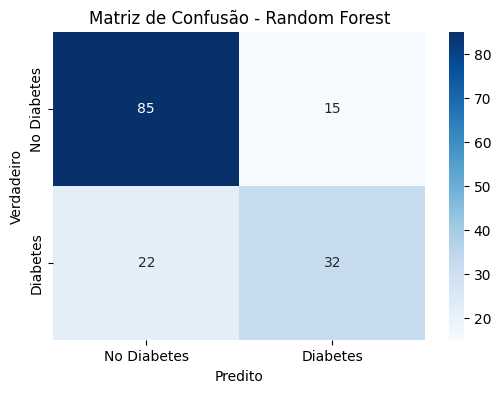

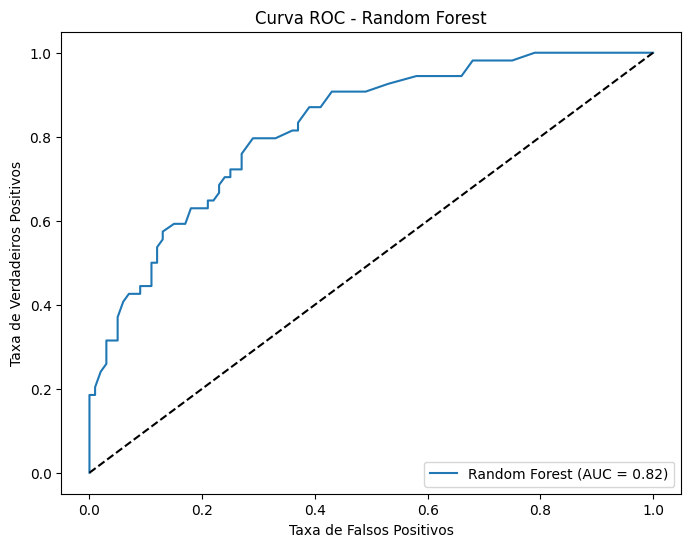

,Feature,Importance
1,Glucose,0.277013
5,BMI,0.163056
6,DiabetesPedigreeFunction,0.123334
7,Age,0.119859
2,BloodPressure,0.087446
0,Pregnancies,0.082304
4,Insulin,0.074398
3,SkinThickness,0.072591


In [23]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
importances = random_forest.feature_importances_

# 1. Importância das Variáveis
# Obter as importâncias e ordenar
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Gráfico de importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importância das Variáveis - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.show()

# 2. Matriz de Confusão
y_pred_forest = random_forest.predict(X_test)
cm = confusion_matrix(y_test, y_pred_forest)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

# 3. Curva ROC e AUC
y_proba_forest = random_forest.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_forest)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.show()

feature_importance_df


Aqui estão os insights detalhados sobre o desempenho do modelo Random Forest:

1. Importância das Variáveis:
* A variável Glucose é a mais importante no modelo, seguida por BMI e DiabetesPedigreeFunction. Isso sugere que esses fatores são altamente relevantes para o diagnóstico de diabetes neste conjunto de dados.
* A Idade também apresenta uma importância considerável, o que é consistente com a observação de que a probabilidade de diabetes aumenta com a idade.
2. Matriz de Confusão:

* A matriz de confusão mostra a quantidade de classificações corretas e incorretas em termos de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos. Esse equilíbrio entre os tipos de erro é essencial para interpretar como o modelo lida com cada classe.
3. Curva ROC e AUC:

* A área sob a curva (AUC) para o modelo Random Forest é de aproximadamente 0,82, o que indica uma boa capacidade de discriminar entre as classes (diabetes e não diabetes).

Essas análises reforçam que o modelo Random Forest é robusto para este problema, com destaque para a glicose, BMI, e histórico familiar como variáveis-chave no diagnóstico.